In [1]:
import numpy as np
import sacpy as scp
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# load sst
sst = scp.load_sst()['sst']
# get ssta
ssta = scp.get_anom(sst,method=1)
# calculate Nino3.4
Nino34 = ssta.loc[:,-5:5,190:240].mean(axis=(1,2))

Nino34_ar = np.array(Nino34)
ssta_ar = np.array(ssta)

In [ ]:
import scipy.stats as sts


def for_loop_reg(nino34, ssta):
    rvalue = np.zeros_like(ssta[0])
    p = np.zeros_like(ssta[0])
    for i in range(rvalue.shape[0]):
        for j in range(rvalue.shape[1]):
            res = sts.linregress(nino34, ssta[:, i, j])
            rvalue[i, j], p[i, j] = res.rvalue, res.pvalue
    return rvalue, p

In [ ]:
var_for_np = np.concatenate([ssta_ar.reshape((Nino34_ar.shape[0], -1)), 
        Nino34_ar[:, np.newaxis]], axis=1).T
var_for_np.shape

(16201, 496)

In [ ]:
%time for i in range(50): xr.corr(ssta,Nino34,dim="time")

CPU times: user 7.8 s, sys: 0 ns, total: 7.8 s
Wall time: 7.84 s


In [ ]:
%time for i in range(50): scp.LinReg(Nino34_ar,ssta_ar)

CPU times: user 4.42 s, sys: 3.8 s, total: 8.22 s
Wall time: 1.54 s


In [ ]:
%time for i in range(50): rvalue, p = for_loop_reg(Nino34_ar, ssta_ar)

CPU times: user 1min 28s, sys: 0 ns, total: 1min 28s
Wall time: 1min 28s


In [ ]:
%time for i in range(50): np.corrcoef(var_for_np)

CPU times: user 9min 6s, sys: 1min 57s, total: 11min 3s
Wall time: 5min 10s


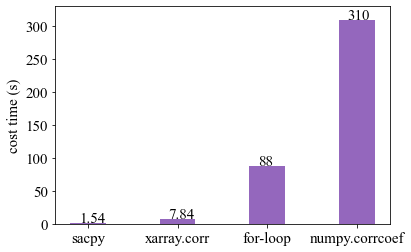

In [73]:
time_list = [1.54,7.84,88,310]
plt.rc('font', family='Times New Roman', size=15)
names = ["sacpy","xarray.corr","for-loop","numpy.corrcoef"]
x = np.arange(4)
plt.bar(x,time_list,width=0.4,color="C4")
plt.xticks(x,names)
for i in range(4):
    plt.text(x[i]-0.1,time_list[i]+1.1
    ,list(map(lambda x:str(x),time_list))[i])
plt.ylabel("cost time (s)")
plt.ylim(0,330)
plt.savefig("../pic/speed_test_00.png")
